<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/data_collection_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1: Install Required Libraries

In [4]:
!pip install yfinance

In [15]:
!pip install prophet

## Importing Libraries

In [42]:
# Data handling and visualization
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# For time series analysis and statistical modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For Facebook Prophet (time series forecasting)
from prophet import Prophet

# For LSTM and deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# For model evaluation and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For sentiment analysis (if you are incorporating sentiment data)
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup

# For risk analysis
import scipy.stats as stats

# Streamlit for web application (user interface)
# import streamlit as st

In [58]:
end = datetime.now()
start = datetime(end.year - 15, end.month, end.day)
stock = 'BTC-USD'
df = yf.download(stock, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [59]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


## Data Cleaning

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3789 entries, 2014-09-17 to 2025-01-31
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   3789 non-null   float64
 1   (High, BTC-USD)    3789 non-null   float64
 2   (Low, BTC-USD)     3789 non-null   float64
 3   (Open, BTC-USD)    3789 non-null   float64
 4   (Volume, BTC-USD)  3789 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 177.6 KB


Flatten the MultiIndex: The columns have a MultiIndex format (Column Name, Coin Ticker).

In [61]:
df.columns = df.columns.get_level_values(0)  # This will get only the first part of the tuple

Rename the columns: Renaming the columns to make them more readable. Removing the ticker from the column names and just keeping the price-related terms.



In [62]:
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

In [63]:
# Check the cleaned data
print(df.head())

                 Close        High         Low        Open    Volume
Date                                                                
2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100


## Data Preprocessing

### 1. Visualizing the Data

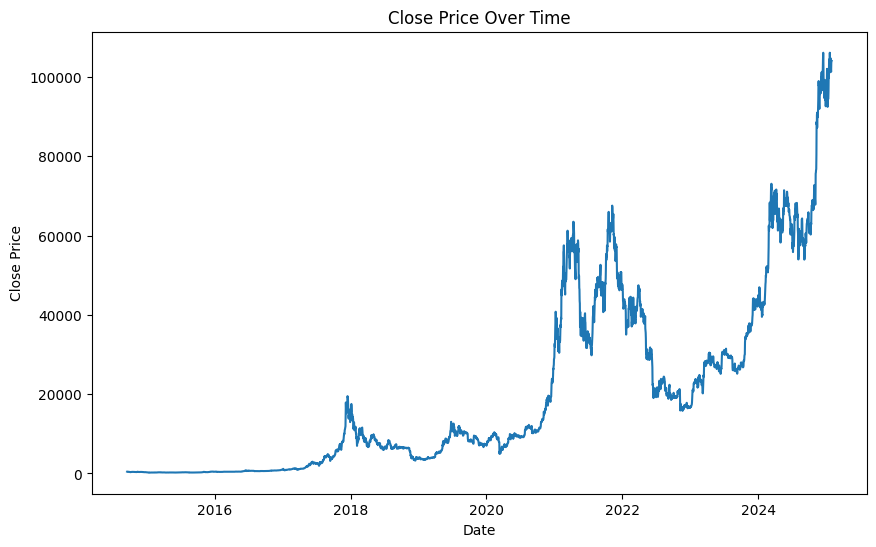

In [76]:
# Visualize the data to check for trends or seasonality
plt.figure(figsize=(10, 6))
plt.plot(close_price)
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

### 2. Checking for Stationarity

For ARIMA and SARIMA models to work effectively, the time series should be stationary. A stationary time series means its statistical properties (mean, variance, etc.) do not change over time.



#### Augmented Dickey-Fuller (ADF) Test:

In [69]:
result = adfuller(df['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('Series is not stationary, differencing is needed.')
else:
    print('Series is stationary.')

ADF Statistic: 0.6464986306263074
p-value: 0.9887073913049923
Series is not stationary, differencing is needed.


### 3.Differencing to Achieve Stationarity

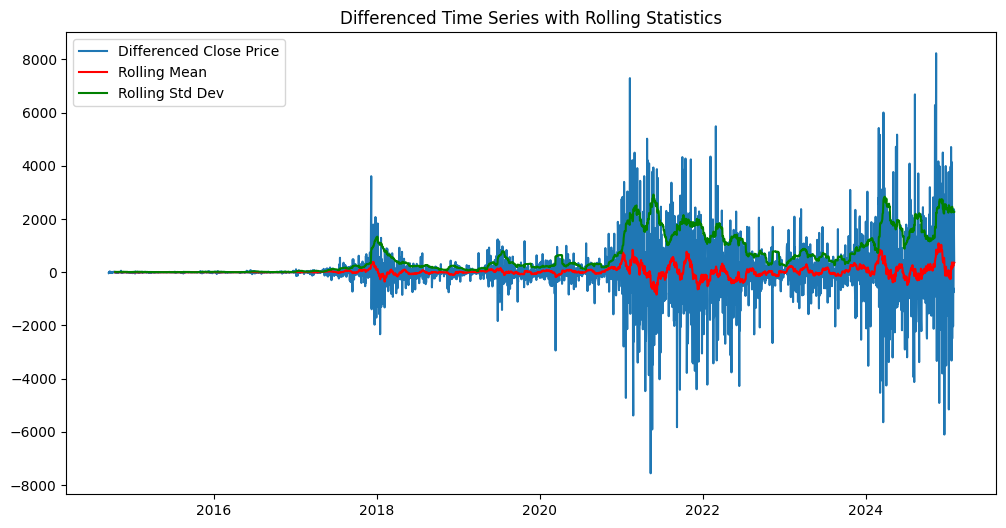

In [72]:
# First-order differencing
df['Close_diff'] = df['Close'].diff()

# Drop the first row since differencing creates NaN
df.dropna(inplace=True)

# Compute rolling statistics
rolling_mean = df['Close_diff'].rolling(window=30).mean()
rolling_std = df['Close_diff'].rolling(window=30).std()

# Plot the differenced series and rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(df['Close_diff'], label='Differenced Close Price')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.legend()
plt.title('Differenced Time Series with Rolling Statistics')
plt.show()

### 4. Checking for seasonality using seasonal decomposition

SARIMA handles seasonality explicitly by adding seasonal components. Checking for seasonality for SARIMA.

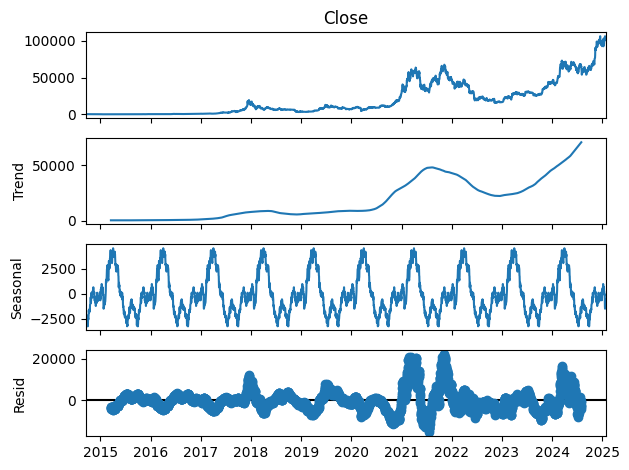

In [71]:
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
decomposition.plot()
plt.show()

### 5. Visualize Autocorrelations and Partial Autocorrelations

For ARIMA and SARIMA, the ACF plot helps determine the MA (Moving Average) term, while the PACF plot helps determine the AR (Auto-Regressive) term.

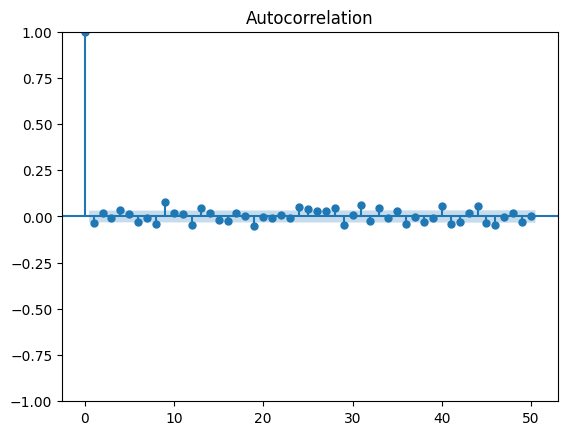

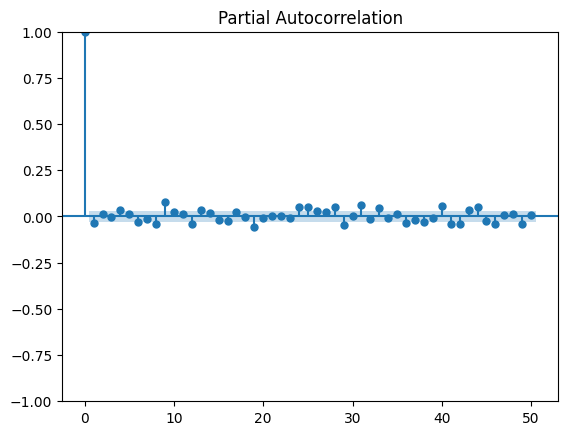

In [77]:
plot_acf(df['Close_diff'], lags=50)  # ACF plot for differenced series
plt.show()

plot_pacf(df['Close_diff'], lags=50)  # PACF plot for differenced series
plt.show()


### 6. Scaling Data

Scaling the data is an important preprocessing step that helps improve the performance and convergence of machine learning and time series models.

### MinMaxScaler?

The **MinMaxScaler** transforms the data to a range of 0 to 1. It is particularly useful for neural networks (like LSTM), as it ensures all features are on the same scale, improving training efficiency.

### Conclusion

- **For ARIMA and SARIMA**: Scaling is optional but can be used to reduce fluctuations and improve consistency.
- **For Prophet**: Scaling is optional, though it can help with extreme values.
- **For LSTM**: Scaling is crucial for effective model training, as neural networks perform best when input data is standardized or normalized.

By scaling the data, we ensure that all models can learn from the time series data effectively and efficiently.


In [78]:
# Apply MinMax scaling to the 'Close' price for models like LSTM
scaler = MinMaxScaler()
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

# Show the first few rows of the scaled data
print(df[['Close', 'Close_scaled']].head())


                 Close  Close_scaled
Date                                
2014-09-18  424.440002      0.002325
2014-09-19  394.795990      0.002045
2014-09-20  408.903992      0.002178
2014-09-21  398.821014      0.002083
2014-09-22  402.152008      0.002114


### 7. Train-Test Split

In [79]:
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

## Save Preprocessed Data

At the end of the data preprocessing steps in 1_data_collection_preprocessing.ipynb, save the cleaned and preprocessed data (Bitcoin price data in this case) to a CSV file or pickled format. This will allow you to import the data into the ARIMA and SARIMA models in the next notebook.

In [80]:
# Save cleaned data to a CSV file after preprocessing
df.to_csv('preprocessed_bitcoin_data.csv')